In [4]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.display import HTML,SVG
from pydae.svg_tools import svg,grid2svg
import pydae.plot_tools as pplt
import scipy.optimize as sopt
from pydae.urisi.lines import change_line
colors = pplt.set_style(plt)

In [5]:
from pydae.urisi.utils import report_v
from pydae.urisi.utils import get_v

In [6]:
import acdc_7bus

In [7]:
model = acdc_7bus.model()  # model instance

# powers at buses:
p_load_A1, q_load_A1 =  0.0e3, 0.0
p_load_A2, q_load_A2 =  000.0e3, 0.0
p_load_A3, q_load_A3 =  000.0e3, 0.0
p_load_A4, q_load_A4 =  300.0e3, 0.0
p_load_D2 =  0.0e3
p_load_D3 =  0.0e3
p_load_D4 =  0.0e3

# vsc powers:
p_vsc_A3 = 0.0e3
q_vsc_A3 = 0.0e3

params = { #"K_xif":0.01,
'p_load_A2_a':p_load_A2/3,'p_load_A2_b':p_load_A2/3,'p_load_A2_c':p_load_A2/3,
'q_load_A2_a':q_load_A2/3,'q_load_A2_b':q_load_A2/3,'q_load_A2_c':q_load_A2/3,
'p_load_A3_a':p_load_A3/3,'p_load_A3_b':p_load_A3/3,'p_load_A3_c':p_load_A3/3,
'q_load_A3_a':q_load_A3/3,'q_load_A3_b':q_load_A3/3,'q_load_A3_c':q_load_A3/3,
'p_load_A4_a':p_load_A4/3,'p_load_A4_b':p_load_A4/3*0,'p_load_A4_c':p_load_A4/3*0,
'q_load_A4_a':q_load_A4/3,'q_load_A4_b':q_load_A4/3,'q_load_A4_c':q_load_A4/3,
'p_load_D2':  p_load_D2,
'p_load_D3':  p_load_D3,
'p_load_D4':  p_load_D4,
'K_acdc_A4': 10000e3
}

In [8]:
model.ini(params,'xy_0.json')
# model.step(0.1,{})
# model.report_y() # get all algebraic values
# report_v(model,'acdc_7bus.hjson'); # report voltages
get_v(model,'A4','V_abcn_m') # get particular bus voltages (modules)
get_v(model,'A4','V_abcn_m') # get particular bus voltages (phase to neutral modules)
get_v(model,'A4','U_ab_m')   # get particular bus voltages (phase to phase modules)
model.get_value('i_l_A2_0_A3_0_r')

68.11989933421575

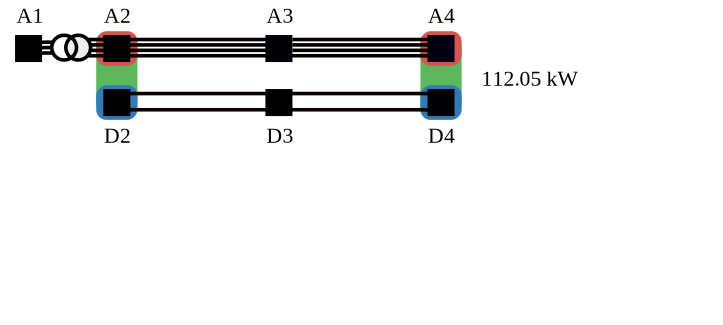

In [9]:
s = svg('acdc_7bus.svg')
s.set_grid(model,'acdc_7bus.hjson')
s.set_text('PLOSS',f"{model.get_value('p_A1')/1000:5.2f} kW")
s.set_tooltips('acdc_7bus_tooltips.svg')    
SVG('acdc_7bus_tooltips.svg')

In [10]:
class ofo:

    def __init__(self):
        '''

        u: p and q of the VSC at bus A4  (u = [p_vsc_ref_A4, q_vsc_A4])
        y: total demanded power, apparent power of VSC at bus A4 and A4 bus voltage (y = [P_total, S_vsc_A4, V_A4])

        0.95 < V_A4 < 1.05


        V_A4 > 0.95 =>  -V_A4 < -0.95

        -V_A4 < -0.95
        V_A4 < 1.05
        S_vsc_A4 < 1.0

        '''

        self.p_vsc_ref_A4 = 0.0
        self.q_vsc_A4 = 0.0

        self.u = np.zeros((2,1), dtype=np.float64)
        self.y = np.zeros((3,1), dtype=np.float64)

        self.rho = 10
        self.alpha = 0.01

        self.N_y = len(self.y)
        self.N_c = 3

        self.A = np.array([1,0,0]).reshape((1,self.N_y))
        self.A = np.array([[ 1],
                           [ 0],
                           [ 0]])   

        self.y_lims = np.array([ -0.95, 1.05, 1.0]).reshape(3,1)  # d vector at PSCC paper

        self.C = np.array([[ 0, 0,-1],  #    -V_A4 < -0.95
                           [ 0, 0, 1],  #     V_A4 < 1.05
                           [ 0, 1, 0]]) # S_vsc_A4 < 1.0   

   
    def set_model(self, model):

        self.model = model

        # powers at buses:
        p_load_A1, q_load_A1 =  0.0e3, 0.0
        p_load_A2, q_load_A2 =  000.0e3, 0.0
        p_load_A3, q_load_A3 =  000.0e3, 0.0
        p_load_A4, q_load_A4 =  500.0e3, 0.0
        p_load_D2 =  0.0e3
        p_load_D3 =  0.0e3
        p_load_D4 =  0.0e3

        # vsc powers:
        p_vsc_A3 = 0.0e3
        q_vsc_A3 = 0.0e3

        self.p_load_A4 = p_load_A4

        self.params = { #"K_xif":0.01,
        'p_load_A2_a':p_load_A2/3,'p_load_A2_b':p_load_A2/3,'p_load_A2_c':p_load_A2/3,
        'q_load_A2_a':q_load_A2/3,'q_load_A2_b':q_load_A2/3,'q_load_A2_c':q_load_A2/3,
        'p_load_A3_a':p_load_A3/3,'p_load_A3_b':p_load_A3/3,'p_load_A3_c':p_load_A3/3,
        'q_load_A3_a':q_load_A3/3,'q_load_A3_b':q_load_A3/3,'q_load_A3_c':q_load_A3/3,
        'p_load_A4_a':p_load_A4/3,'p_load_A4_b':p_load_A4/3,'p_load_A4_c':p_load_A4/3,
        'q_load_A4_a':q_load_A4/3,'q_load_A4_b':q_load_A4/3,'q_load_A4_c':q_load_A4/3,
        'p_load_D2':  p_load_D2,
        'p_load_D3':  p_load_D3,
        'p_load_D4':  p_load_D4,
        'K_acdc_A4': 1000e3
        }

        p_vsc_ref_A4 = self.p_vsc_ref_A4
        q_vsc_A4 = self.q_vsc_A4

        self.params.update({'p_vsc_a_ref_A4':p_vsc_ref_A4/3,
                            'p_vsc_b_ref_A4':p_vsc_ref_A4/3,
                            'p_vsc_c_ref_A4':p_vsc_ref_A4/3,
                            'q_vsc_a_A4':q_vsc_A4/3,
                            'q_vsc_b_A4':q_vsc_A4/3,
                            'q_vsc_c_A4':q_vsc_A4/3
                            })  # now this has no sense because active power 
        
        self.model.ini(self.params,'xy_0.json')

    def objective(self,u):
        y = self.system(u)
        f = self.A.T @ y
        return f

    def system(self,u):    # h(u,w) in the PSCC paper      

        p_vsc_ref_A4 = u[0,0]*100e3
        q_vsc_A4 = u[1,0]*100e3

        self.params.update({'p_vsc_a_ref_A4':p_vsc_ref_A4/3,
                            'p_vsc_b_ref_A4':p_vsc_ref_A4/3,
                            'p_vsc_c_ref_A4':p_vsc_ref_A4/3})   
        self.params.update({'q_vsc_a_A4':q_vsc_A4/3,
                            'q_vsc_b_A4':q_vsc_A4/3,
                            'q_vsc_c_A4':q_vsc_A4/3})         
                                                                                            
        self.model.ini(self.params)  # ini/power flow

        # total microgrid power
        self.p_total = self.model.get_value('p_A1') 
        self.p_loss = self.p_total - self.p_load_A4 

        # converter aparent power
        s_vsc_A4 = self.model.get_value('p_vsc_A4')
        
        # A4 bus voltage
        V_4 = np.average(get_v(self.model,'A4','V_abcn_m')) 

        # system outputs
        y = np.array([[self.p_loss/100e3],
                      [s_vsc_A4/100e3], 
                      [V_4/231]])

        self.y = y

        return y

    def dL(self,u, y, mu, s):
        y = self.system(u)
        H = self.H
        y_lims = self.y_lims
        rho = self.rho
        A = self.A
        C = self.C
        
        #return H.T@C.T@(mu + C@y) # H.T@A  +  #  #+ H.T@C.T@(mu + rho*(C@y - y_lims + s))
        return  H.T@A + H.T@C.T@( mu + rho*(C@y - y_lims + s)) # H.T@A  +  #  #+ H.T@C.T@(mu + rho*(C@y - y_lims + s))


    def H_eval(self, inc=0.02):
        N_u = self.u.shape[0]
        N_y = self.y.shape[0]
        H = np.zeros((N_y,N_u), dtype=np.float64)

        y = self.system(self.u)
        for i_u in range(N_u):
            u_0 = self.u[i_u,0]
            
            self.u[i_u,0] = u_0 + inc

            y_pos = self.system(self.u)

            H[:,i_u] = ((y_pos - y)/inc)[:,0]

            self.u[i_u,0] = u_0
            y = self.system(self.u)

        self.H = H

        return H
        
        #return -2*np.array([[1, 0], [0, 1]])@u + H*C*(mu + rho*(C*y - d + s))
    

    def solve(self):

        # Inicializamos
        u = np.array([0.0, 0.0]).reshape(2,1)
        s = np.zeros((3,1))
        mu = np.zeros((3,1))
        rho = self.rho
        y = self.system(u)
        alpha = self.alpha
        y_lims = self.y_lims
        C = self.C
        self.s = s
        self.mu = mu
        
        #%% Algoritmo iterativo

        # L = f(x) + \mu*(y + s) + (\rho/2)*||y + s||_2^2  

        for iteration in range(1000):

            # 1. Update slack variables (Paper PSCC)
            s = -(1/rho)*mu - C@y + y_lims
            for it in range(len(s)):
                if s[it,0] < 0:
                    s[it,0] = 0
            
            # 2. Update control signals
            u = u - alpha*self.dL(u, y, mu, s)
        
            # 3. Dispatch signals
            y = self.system(u)
        
            # 4. Update Lagrange multipliers
            mu = mu + rho*(C@y - y_lims + s)


            # algorithm ends here

            # the rest of the iteration loop is just for reporting

            self.y_lims_ref = C@y
            #o.H_eval(inc=0.2)

            string = ''
            string += f'it = {iteration:3d}, '
            string += f'fo = {self.objective(u)[0,0]:0.2f}, '
            string += f'p_ref = {u[0,0]:0.2f}, '
            string += f'q_ref = {u[1,0]:0.2f}, '
            #string += f'H[0,0] = {self.H[0,0]:0.3f}, H[0,1] = {self.H[0,1]:0.3f}, '
            #string += f'y[0,0] = {self.y[0,0]:0.3f}, y[1,0] = {self.y[1,0]:0.3f}, y[2,0] = {self.y[2,0]:0.3f}, '
            string += f'yr[0] = {self.y_lims_ref[0,0]:0.2f} < {y_lims[0,0]:0.2f}, '
            string += f'yr[1] = {self.y_lims_ref[1,0]:0.2f} < {y_lims[1,0]:0.2f}, '
            string += f'yr[2] = {self.y_lims_ref[2,0]:0.2f} < {y_lims[2,0]:0.2f}, '

            string += f'V_4 = {y[2,0]:0.3f} '
                
            print(f'\r {string}', end='')

o = ofo()
model = acdc_7bus.model()  # model instance
o.set_model(model)
o.H_eval(inc=0.01)
o.solve()


 it = 999, fo = 2.31, p_ref = 1.39, q_ref = 6.70, yr[0] = -0.99 < -0.95, yr[1] = 0.99 < 1.05, yr[2] = 1.00 < 1.00, V_4 = 0.987  

In [ ]:
o.model.report_params()

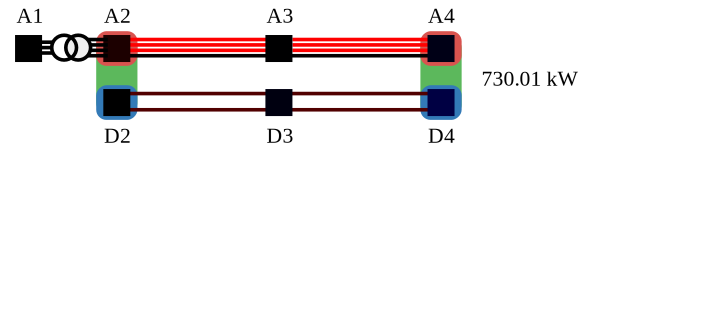

In [18]:
s = svg('acdc_7bus.svg')
s.set_grid(model,'acdc_7bus.hjson')
s.set_text('PLOSS',f"{model.get_value('p_A1')/1000:5.2f} kW")
s.set_tooltips('acdc_7bus_tooltips.svg')    
SVG('acdc_7bus_tooltips.svg')

In [30]:
## Updating OFO

class ofo:

    def __init__(self):
        '''

        u: p and q of the VSC at bus A4  (u = [p_vsc_ref_A4, q_vsc_A4])
        y: total demanded power, apparent power of VSC at bus A4 and A4 bus voltage (y = [P_total, S_vsc_A4, V_A4])

        0.95 < V_A4 < 1.05


        V_A4 > 0.95 =>  -V_A4 < -0.95

        -V_A4 < -0.95
        V_A4 < 1.05
        S_vsc_A4 < 1.0

        '''

        self.p_vsc_ref_A4 = 0.0
        self.q_vsc_A4 = 0.0

        self.u = np.zeros((2,1), dtype=np.float64)
        self.y = np.zeros((3,1), dtype=np.float64)

        self.rho = 10
        self.alpha = 0.01

        self.N_y = len(self.y)
        self.N_c = 3

        self.A = np.array([[1,0,0]]).reshape((1,self.N_y)) ## should be 2D as follow self.A = np.array([[1, 0, 0]]) (Mustafa)
        self.A = np.array([[0, 0, 1],
                           [0, 0, 0],
                           [0, 0, 0]])   

        self.y_lims = np.array([-0.95, 1.05, 1.0]).reshape(3,1)  # d vector at PSCC paper

        self.C = np.array([[ 0, 0,-1],  #    -V_A4 < -0.95
                           [ 0, 0, 1],  #     V_A4 < 1.05
                           [ 0, 1, 0]]) # S_vsc_A4 < 1.0   

   
    def set_model(self, model):

        self.model = model

        # powers at buses:
        p_load_A1, q_load_A1 =  000.0e3, 0.0
        p_load_A2, q_load_A2 =  000.0e3, 0.0
        p_load_A3, q_load_A3 =  000.0e3, 0.0
        p_load_A4, q_load_A4 =  500.0e3, 0.0
        p_load_D2 =  0.0e3
        p_load_D3 =  0.0e3
        p_load_D4 =  0.0e3

        # vsc powers:
        p_vsc_A3 = 0.0e3
        q_vsc_A3 = 0.0e3

        self.p_load_A4 = p_load_A4

        self.params = { #"K_xif":0.01,
        'p_load_A2_a':p_load_A2/3,'p_load_A2_b':p_load_A2/3,'p_load_A2_c':p_load_A2/3,
        'q_load_A2_a':q_load_A2/3,'q_load_A2_b':q_load_A2/3,'q_load_A2_c':q_load_A2/3,
        'p_load_A3_a':p_load_A3/3,'p_load_A3_b':p_load_A3/3,'p_load_A3_c':p_load_A3/3,
        'q_load_A3_a':q_load_A3/3,'q_load_A3_b':q_load_A3/3,'q_load_A3_c':q_load_A3/3,
        'p_load_A4_a':p_load_A4/3,'p_load_A4_b':p_load_A4/3,'p_load_A4_c':p_load_A4/3,
        'q_load_A4_a':q_load_A4/3,'q_load_A4_b':q_load_A4/3,'q_load_A4_c':q_load_A4/3,
        'p_load_D2':  p_load_D2,
        'p_load_D3':  p_load_D3,
        'p_load_D4':  p_load_D4,
        'K_acdc_A4': 1000e3
        }

        p_vsc_ref_A4 = self.p_vsc_ref_A4
        q_vsc_A4 = self.q_vsc_A4

        self.params.update({'p_vsc_a_ref_A4':p_vsc_ref_A4/3,
                            'p_vsc_b_ref_A4':p_vsc_ref_A4/3,
                            'p_vsc_c_ref_A4':p_vsc_ref_A4/3,
                            'q_vsc_a_A4':q_vsc_A4/3,
                            'q_vsc_b_A4':q_vsc_A4/3,
                            'q_vsc_c_A4':q_vsc_A4/3
                            })  # now this has no sense because active power 
        
        self.model.ini(self.params,'xy_0.json')

    def objective(self,u):
        y = self.system(u)
        f = self.A.T @ y
        return f

    def system(self,u):    # h(u,w) in the PSCC paper      

        self.p_vsc_ref_A4 = u[0,0]*100e3  # I think you should define it as self.p_vsc_ref_A4 and same for the rest. (Mustafa)
        self.q_vsc_A4 = u[1,0]*100e3

        self.params.update({'p_vsc_a_ref_A4':self.p_vsc_ref_A4/3,
                            'p_vsc_b_ref_A4':self.p_vsc_ref_A4/3,
                            'p_vsc_c_ref_A4':self.p_vsc_ref_A4/3})   
        self.params.update({'q_vsc_a_A4':self.q_vsc_A4/3,
                            'q_vsc_b_A4':self.q_vsc_A4/3,
                            'q_vsc_c_A4':self.q_vsc_A4/3})         
                                                                                            
        self.model.ini(self.params)  # ini/power flow

        # total microgrid power
        self.p_total = self.model.get_value('p_A1') 
        self.p_loss = self.p_total - self.p_load_A4 

        # converter aparent power
        s_vsc_A4 = self.model.get_value('p_vsc_A4')
        
        # A4 bus voltage
        V_4 = np.average(get_v(self.model,'A4','V_abcn_m')) ## What is get_v, it is Undefined Function (Mustafa)

        # system outputs
        y = np.array([[self.p_loss/100e3],
                      [s_vsc_A4/100e3], 
                      [V_4/231]])

        self.y = y

        return y

    def dL(self,u, y, mu, s):
        y = self.system(u)
        H = self.H
        y_lims = self.y_lims
        rho = self.rho
        A = self.A
        C = self.C
        
        #return H.T@C.T@(mu + C@y) # H.T@A  +  #  #+ H.T@C.T@(mu + rho*(C@y - y_lims + s))
        return  H.T@A + H.T@C.T@( mu + rho*(C@y - y_lims + s)) # H.T@A  +  #  #+ H.T@C.T@(mu + rho*(C@y - y_lims + s)) ## change to the follow (Mustafa)
    


    def H_eval(self, inc=0.02):
        N_u = self.u.shape[0]
        N_y = self.y.shape[0]
        H = np.zeros((N_y,N_u), dtype=np.float64)

        y = self.system(self.u)
        for i_u in range(N_u):
            u_0 = self.u[i_u,0]
            
            self.u[i_u,0] = u_0 + inc

            y_pos = self.system(self.u)

            H[:,i_u] = ((y_pos - y)/inc)[:,0]

            self.u[i_u,0] = u_0
            y = self.system(self.u)

        self.H = H

        return H
        
        #return -2*np.array([[1, 0], [0, 1]])@u + H*C*(mu + rho*(C*y - d + s))

    def solve(self):

        # Inicializamos
        u = np.array([0.0, 0.0]).reshape(2,1)
        s = np.zeros((3,1))
        mu = np.zeros((3,1))
        rho = self.rho
        y = self.system(u)
        alpha = self.alpha
        y_lims = self.y_lims
        C = self.C
        self.s = s
        self.mu = mu
        #%% Algoritmo iterativo

        # L = f(x) + \mu*(y + s) + (\rho/2)*||y + s||_2^2  

        for iteration in range(1000):

            # 1. Update slack variables (Paper PSCC)
            s = -(1/rho)*mu - C@y + y_lims
            for it in range(len(s)):
                if s[it,0] < 0:
                    s[it,0] = 0
            
            # 2. Update control signals
            u = u - alpha*self.dL(u, y, mu, s)
        
            # 3. Dispatch signals
            y = self.system(u)
        
            # 4. Update Lagrange multipliers
            mu = mu + rho*(C@y - y_lims + s)


            # algorithm ends here

            # the rest of the iteration loop is just for reporting

            self.y_lims_ref = C@y
            #o.H_eval(inc=0.2)

            string = ''
            string += f'it = {iteration:3d}, '
            string += f'fo = {self.objective(u)[0,0]:0.2f}, '
            string += f'p_ref = {u[0,0]:0.2f}, '
            string += f'q_ref = {u[1,0]:0.2f}, '
            #string += f'H[0,0] = {self.H[0,0]:0.3f}, H[0,1] = {self.H[0,1]:0.3f}, '
            #string += f'y[0,0] = {self.y[0,0]:0.3f}, y[1,0] = {self.y[1,0]:0.3f}, y[2,0] = {self.y[2,0]:0.3f}, '
            string += f'yr[0] = {self.y_lims_ref[0,0]:0.2f} < {y_lims[0,0]:0.2f}, '
            string += f'yr[1] = {self.y_lims_ref[1,0]:0.2f} < {y_lims[1,0]:0.2f}, '
            string += f'yr[2] = {self.y_lims_ref[2,0]:0.2f} < {y_lims[2,0]:0.2f}, '

            string += f'V_4 = {y[2,0]:0.3f} '
                
            print(f'\r {string}', end='')

o = ofo()
model = acdc_7bus.model()  # model instance
o.set_model(model)
o.H_eval(inc=0.01)
o.solve()


 it = 999, fo = 0.00, p_ref = 1.38, q_ref = 6.69, yr[0] = -0.99 < -0.95, yr[1] = 0.99 < 1.05, yr[2] = 1.00 < 1.00, V_4 = 0.987  

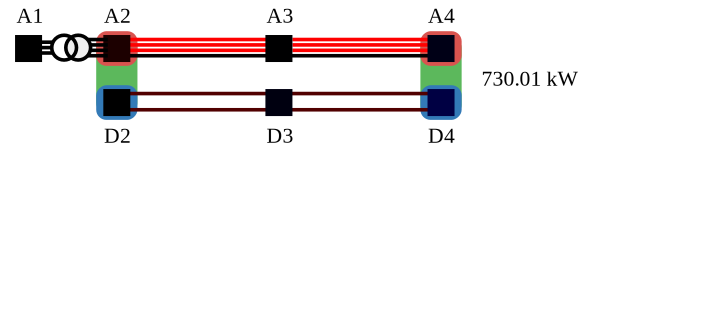

In [31]:
s = svg('acdc_7bus.svg')
s.set_grid(model,'acdc_7bus.hjson')
s.set_text('PLOSS',f"{model.get_value('p_A1')/1000:5.2f} kW")
s.set_tooltips('acdc_7bus_tooltips.svg')    
SVG('acdc_7bus_tooltips.svg')

In [15]:
print(p_total)
print(p_load_A4)
print(p_loss)

get_value('p_A1')
300000.0


NameError: name 'p_loss' is not defined

In [ ]:
### Document ends here

In [ ]:
model = acdc_7bus.model()  # model instance

# powers at buses:
p_load_A1, q_load_A1 =  0.0e3, 0.0
p_load_A2, q_load_A2 =  000.0e3, 0.0
p_load_A3, q_load_A3 =  000.0e3, 0.0
p_load_A4, q_load_A4 =  300.0e3, 0.0
p_load_D2 =  0.0e3
p_load_D3 =  0.0e3
p_load_D4 =  0.0e3

# vsc powers:
p_vsc_A3 = 0.0e3
q_vsc_A3 = 0.0e3

params = { #"K_xif":0.01,
'p_load_A2_a':p_load_A2/3,'p_load_A2_b':p_load_A2/3,'p_load_A2_c':p_load_A2/3,
'q_load_A2_a':q_load_A2/3,'q_load_A2_b':q_load_A2/3,'q_load_A2_c':q_load_A2/3,
'p_load_A3_a':p_load_A3/3,'p_load_A3_b':p_load_A3/3,'p_load_A3_c':p_load_A3/3,
'q_load_A3_a':q_load_A3/3,'q_load_A3_b':q_load_A3/3,'q_load_A3_c':q_load_A3/3,
'p_load_A4_a':p_load_A4/3,'p_load_A4_b':p_load_A4/3*0,'p_load_A4_c':p_load_A4/3*0,
'q_load_A4_a':q_load_A4/3,'q_load_A4_b':q_load_A4/3,'q_load_A4_c':q_load_A4/3,
'p_load_D2':  p_load_D2,
'p_load_D3':  p_load_D3,
'p_load_D4':  p_load_D4,
'K_acdc_A4': 10000e3
}

In [ ]:
model.ini(params,'xy_0.json')
# model.step(0.1,{})
# model.report_y() # get all algebraic values
# report_v(model,'acdc_7bus.hjson'); # report voltages
get_v(model,'A4','V_abcn_m') # get particular bus voltages (modules)
get_v(model,'A4','V_abcn_m') # get particular bus voltages (phase to neutral modules)
get_v(model,'A4','U_ab_m')   # get particular bus voltages (phase to phase modules)
model.get_value('i_l_A2_0_A3_0_r')

In [ ]:
v_ac_a_pu_D4 = model.get_value('v_ac_a_pu_A4')
v_dc_pu_D4 = model.get_value('v_dc_pu_D4')
print(f'v_ac_pu_A4 = {v_ac_a_pu_D4:4.4f}, v_dc_pu_D4 = {v_dc_pu_D4:4.4f}')

In [ ]:
s = svg('acdc_7bus.svg')
s.set_grid(model,'acdc_7bus.hjson')
s.set_text('PLOSS',f"{model.get_value('p_A1')/1000:5.2f} kW")
s.set_tooltips('acdc_7bus_tooltips.svg')    
SVG('acdc_7bus_tooltips.svg')

In [ ]:
o.system(np.array([[0.0],[0.1]]))

In [ ]:
y [[1.12054646]
 [1.        ]
 [0.98933427]]

In [ ]:
o.model.get_value('s_vsc_A4')

In [ ]:
o.model.get_value('q_vsc_A4')

In [ ]:
o.model.report_z()

In [ ]:
p_A1  = 323487.08
q_A1  = 4748.86

In [ ]:
o.H.T@o.A

In [ ]:
100):

            # 1. Update slack variables
            s = -(1/rho)*mu - C*y + y_lims
            for it in range(len(s)):
                if s[it,0] < 0:
                    s[it,0] = 0
            
            # 2. Update control signals
            u = u - alpha*self.dL(u, y, mu, s)
        
            # 3. Dispatch signals
            y = self.system(u)
        
            # 4. Update Lagrange multipliers
            mu = mu + rho*(C@y - y_lims + s)
        
            print(f'it {iteration}: {u}, fo: {self.objective(u):.3f}')

o = ofo()
o.set_model(model)
o.H_eval()
o.solve()

In [ ]:
o.H

In [ ]:
o.C.T

In [ ]:
o.H.T@o.C

In [ ]:
o.C

In [ ]:
p_min = 1e8
p_vsc_min = 0.0
for p_vsc_A4 in np.linspace(-10e3,10e3,200):
   params.update({'p_vsc_a_A4':p_vsc_A4/3,'p_vsc_b_A4':p_vsc_A4/3,'p_vsc_c_A4':p_vsc_A4/3,})  # now this has no sense because active power 
                                                                                              # is defined by the droop
   model.ini(params)
   model.step(0.001,{})
   p_total = model.get_value('p_A1')
   if p_total < p_min:
       p_min = p_total
       p_vsc_min = p_vsc_A3
   print(f"VSC A4 power = {p_vsc_A4/1000:8.3f} kW, Total power = {p_total/1000:5.3f} kW")
print(f"Minimum: VSC A4 power = {p_vsc_min/1000:8.3f} kW, Total power = {p_min/1000:5.3f} kW")

In [ ]:
model.report_u()

In [ ]:
data_line_code = {"R":[[ 0.211, 0.049, 0.049, 0.049],[ 0.049, 0.211, 0.049, 0.049], [ 0.049, 0.049, 0.211, 0.049], [ 0.049, 0.049, 0.049, 0.211]],
                  "X":[[ 0.747, 0.673, 0.651, 0.673],[ 0.673, 0.747, 0.673, 0.651], [ 0.651, 0.673, 0.747, 0.673], [ 0.673, 0.651, 0.673, 0.747]], "I_max":430.0}

change_line(model,'A2','A3',data_line_code, 100)
model.ini(params,'xy_0.json')

In [ ]:
model.report_z()